In [18]:
# --- Common Utilities and Setup ---
import os
import json
import torch
import transformers
import accelerate
import huggingface_hub
import peft
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score
from sklearn.utils import resample
from collections import Counter
import time
import onnxruntime as ort
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from typing import List
import pickle

print("peft:", peft.__version__)
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("Accelerate:", accelerate.__version__)
print("Huggingface Hub:", huggingface_hub.__version__)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

peft: 0.14.0
Torch: 2.2.2
Transformers: 4.49.0
Accelerate: 1.4.0
Huggingface Hub: 0.29.1


In [19]:
def update_model_dict(model_alias, MODEL_NAME):
    if not os.path.exists('model_dict.json'):
        model_dict = {}
    else:
        with open('model_dict.json', 'r') as file:
            model_dict = json.load(file)

    model_dict[model_alias] = MODEL_NAME

    with open('model_dict.json', 'w') as file:
        json.dump(model_dict, file)

In [20]:
def load_and_preprocess_data(filepath="./data/train-00000-of-00001-a5a7c6e4bb30b016.parquet"):
    """Loads and preprocesses the dataset."""
    df = pd.read_parquet(filepath)
    df = df[['conversation', 'issue_area']]
    print("Original distribution:\n", df['issue_area'].value_counts())
    label_encoder = LabelEncoder()
    df["labels"] = label_encoder.fit_transform(df["issue_area"])

    #saving Label-encoder
    label_encoder_path = f"model-metric/{model_alias}/label_encoder.pkl"
    os.makedirs(os.path.dirname(label_encoder_path), exist_ok=True)
    with open(label_encoder_path, "wb") as f:
        pickle.dump(label_encoder, f)
        
    return df, label_encoder

In [21]:
def balance_dataset(df, max_count=100, random_state=42):
    """Balances the dataset using oversampling."""
    balanced_df = pd.DataFrame()
    for issue in df['issue_area'].unique():
        subset = df[df['issue_area'] == issue]
        balanced_subset = resample(subset, replace=True, n_samples=max_count, random_state=random_state)
        balanced_df = pd.concat([balanced_df, balanced_subset])
    return balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)


In [22]:
def preprocess_conversation(conversation):
    """Preprocesses a conversation."""
    if isinstance(conversation, list):
        return " ".join([turn.get('text', '') for turn in conversation if isinstance(turn, dict)])
    return str(conversation).lower()

In [23]:
# Define PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        inputs = self.tokenizer(
            row["conversation"],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)
        label = torch.tensor(row["labels"], dtype=torch.long)
        return input_ids, attention_mask, label

In [24]:
def create_dataloaders(df, tokenizer, batch_size=8, train_ratio=0.75):
    """Creates train and test DataLoaders."""
    train_size = int(train_ratio * len(df))
    train_df, test_df = df[:train_size], df[train_size:]
    train_dataset = CustomDataset(train_df, tokenizer)
    test_dataset = CustomDataset(test_df, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader, test_df

In [25]:
class DistilBERTWithLoRA(nn.Module):
    def __init__(self, num_labels, lora_r=8, lora_alpha=16, lora_dropout=0.1):
        super(DistilBERTWithLoRA, self).__init__()
        # Load the base model with the correct number of labels
        self.bert = AutoModelForSequenceClassification.from_pretrained(
            "distilbert/distilbert-base-uncased",
            num_labels=num_labels  # Ensure this matches the number of classes
        )
        
        # # LoRA Configuration
        # lora_config = LoraConfig(
        #     task_type=TaskType.SEQ_CLS,
        #     r=lora_r,
        #     lora_alpha=lora_alpha,
        #     lora_dropout=lora_dropout,
        #     target_modules=["q_lin", "k_lin", "v_lin"]
        # )
        # self.bert = get_peft_model(self.bert, lora_config)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits  # Return the logits directly

In [26]:
# Function to compute class weights
def compute_class_weights(labels, num_classes):
    counter = Counter(labels)
    total_samples = len(labels)
    weights = [total_samples / (num_classes * counter[i]) for i in range(num_classes)]
    return torch.tensor(weights, dtype=torch.float)

In [27]:
def train_model(model, train_loader, model_alias, epochs=3, learning_rate=5e-5, class_weights=None):
    """Trains the model and saves logs, metrics, and model weights."""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    # Create directory for storing model metrics
    model_dir = f"model-metric/{model_alias}"
    os.makedirs(model_dir, exist_ok=True)

    # TensorBoard writer in the model directory
    writer = SummaryWriter(log_dir=model_dir)

    # Set up loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device) if class_weights is not None else None)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    epoch_losses = []
    metrics_data = []

    for epoch in range(epochs):
        start_time = time.time()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch_idx, batch in enumerate(train_loader):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().tolist()
            labels = labels.cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels)

            # Log batch loss every 10 batches
            if batch_idx % 10 == 0:
                writer.add_scalar("BatchLoss/train", loss.item(), epoch * len(train_loader) + batch_idx)

        # Compute epoch metrics
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
        epoch_time = time.time() - start_time

        # Store metrics for CSV logging
        metrics_data.append([epoch + 1, avg_loss, accuracy, precision, recall, f1, epoch_time])

        # Print metrics
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1:.4f}, Time={epoch_time:.2f}s")

        # Log metrics to TensorBoard
        writer.add_scalar("Loss/train", avg_loss, epoch)
        writer.add_scalar("Accuracy/train", accuracy, epoch)
        writer.add_scalar("Precision/train", precision, epoch)
        writer.add_scalar("Recall/train", recall, epoch)
        writer.add_scalar("F1-score/train", f1, epoch)
        writer.add_scalar("Time/Epoch", epoch_time, epoch)

    # Save model KPIs as CSV
    metrics_df = pd.DataFrame(metrics_data, columns=["Epoch", "Loss", "Accuracy", "Precision", "Recall", "F1-score", "Time (s)"])
    metrics_df.to_csv(os.path.join(model_dir, "training_metrics.csv"), index=False)

    # Save training loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    loss_plot_path = os.path.join(model_dir, "training_loss.png")
    plt.savefig(loss_plot_path)
    writer.add_figure("Training Loss", plt.gcf(), close=True)

    # Save model weights
    model_path = os.path.join(model_dir, f"{model_alias}.pth")
    torch.save(model.state_dict(), model_path)

    writer.flush()
    writer.close()


In [28]:
import os
import time
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

def evaluate_model(model, test_loader, label_encoder, model_alias):
    """Evaluates the model and saves metrics, logs, and confusion matrix."""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Create directory for storing model metrics
    model_dir = f"model-metric/{model_alias}"
    os.makedirs(model_dir, exist_ok=True)

    # Initialize TensorBoard writer
    writer = SummaryWriter(log_dir=model_dir)

    all_preds, all_labels = [], []
    start_time = time.time()

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1).cpu().tolist()
            labels = labels.cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels)

    eval_time = time.time() - start_time
    class_names = label_encoder.classes_

    # Compute metrics
    precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average=None)
    class_metrics = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })

    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    # Print and save classification report
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()

    # Save confusion matrix plot
    confusion_matrix_path = os.path.join(model_dir, "confusion_matrix.png")
    plt.savefig(confusion_matrix_path)
    writer.add_figure("Confusion Matrix", plt.gcf(), close=True)

    # Print overall metrics
    print("\nPer-class Metrics:\n", class_metrics.to_string(index=False))
    print(f"\nOverall Metrics:\nPrecision: {overall_precision:.4f}, Recall: {overall_recall:.4f}, F1-score: {overall_f1:.4f}, Eval Time: {eval_time:.2f}s")

    # Log metrics to TensorBoard
    writer.add_scalar("Precision/test", overall_precision)
    writer.add_scalar("Recall/test", overall_recall)
    writer.add_scalar("F1-score/test", overall_f1)
    writer.add_scalar("Evaluation Time", eval_time)

    # Log per-class metrics
    for i, class_name in enumerate(class_names):
        writer.add_scalar(f"Precision/{class_name}", precision[i])
        writer.add_scalar(f"Recall/{class_name}", recall[i])
        writer.add_scalar(f"F1-score/{class_name}", f1[i])

    writer.flush()
    writer.close()

    # Save evaluation metrics
    class_metrics.to_csv(os.path.join(model_dir, "class_metrics.csv"), index=False)
    cm_df.to_csv(os.path.join(model_dir, "confusion_matrix.csv"))

    return class_metrics, cm_df


In [29]:
def compute_class_weights(labels, num_classes):
    counter = Counter(labels)
    total_samples = len(labels)
    weights = [total_samples / (num_classes * counter[i]) for i in range(num_classes)]
    return torch.tensor(weights, dtype=torch.float)

In [30]:
MODEL_NAME = "distilbert/distilbert-base-uncased-pruned"
model_alias = 'distilbert-cased-lora'
update_model_dict(model_alias, MODEL_NAME)

In [31]:
df, label_encoder = load_and_preprocess_data()
balanced_df = balance_dataset(df)
balanced_df['conversation'] = balanced_df['conversation'].apply(preprocess_conversation)

Original distribution:
 issue_area
Cancellations and returns    286
Order                        270
Login and Account            151
Shopping                     116
Warranty                     105
Shipping                      72
Name: count, dtype: int64


In [32]:
    # Tokenization and DataLoaders
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
train_loader, test_loader, test_df = create_dataloaders(balanced_df, tokenizer)

In [33]:
# Model Initialization and Training
num_classes = len(label_encoder.classes_)
model = DistilBERTWithLoRA(num_labels=num_classes)
class_weights = compute_class_weights(balanced_df['labels'], num_classes)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
train_model(model, train_loader,model_alias=model_alias, epochs=5, learning_rate=5e-5, class_weights=class_weights)

Epoch 1: Loss=1.3354, Accuracy=0.5333, Precision=0.5813, Recall=0.5333, F1-score=0.5282, Time=237.63s
Epoch 2: Loss=0.4718, Accuracy=0.8911, Precision=0.8907, Recall=0.8911, F1-score=0.8884, Time=161.25s
Epoch 3: Loss=0.2097, Accuracy=0.9422, Precision=0.9438, Recall=0.9422, F1-score=0.9414, Time=169.82s
Epoch 4: Loss=0.1100, Accuracy=0.9778, Precision=0.9778, Recall=0.9778, F1-score=0.9778, Time=166.13s
Epoch 5: Loss=0.0435, Accuracy=0.9911, Precision=0.9911, Recall=0.9911, F1-score=0.9911, Time=161.50s


In [35]:
# Model Evaluation
evaluate_model(model, test_loader, label_encoder, model_alias)


Classification Report:
                            precision    recall  f1-score   support

Cancellations and returns       0.90      0.95      0.93        20
        Login and Account       1.00      0.93      0.96        28
                    Order       0.86      0.83      0.85        30
                 Shipping       0.88      1.00      0.94        23
                 Shopping       0.95      0.95      0.95        22
                 Warranty       1.00      0.96      0.98        27

                 accuracy                           0.93       150
                macro avg       0.93      0.94      0.94       150
             weighted avg       0.94      0.93      0.93       150


Per-class Metrics:
                     Class  Precision   Recall  F1-Score  Support
Cancellations and returns   0.904762 0.950000  0.926829       20
        Login and Account   1.000000 0.928571  0.962963       28
                    Order   0.862069 0.833333  0.847458       30
                 Ship

(                       Class  Precision    Recall  F1-Score  Support
 0  Cancellations and returns   0.904762  0.950000  0.926829       20
 1          Login and Account   1.000000  0.928571  0.962963       28
 2                      Order   0.862069  0.833333  0.847458       30
 3                   Shipping   0.884615  1.000000  0.938776       23
 4                   Shopping   0.954545  0.954545  0.954545       22
 5                   Warranty   1.000000  0.962963  0.981132       27,
                            Cancellations and returns  Login and Account  \
 Cancellations and returns                         19                  0   
 Login and Account                                  0                 26   
 Order                                              2                  0   
 Shipping                                           0                  0   
 Shopping                                           0                  0   
 Warranty                                           0

In [36]:
# Save tokenizer
tokenizer_path = f"model-metric/{model_alias}/tokenizer/"
print(f"Saving tokenizer to {tokenizer_path}")
tokenizer.save_pretrained(tokenizer_path)

Saving tokenizer to model-metric/distilbert-cased-lora/tokenizer/


('model-metric/distilbert-cased-lora/tokenizer/tokenizer_config.json',
 'model-metric/distilbert-cased-lora/tokenizer/special_tokens_map.json',
 'model-metric/distilbert-cased-lora/tokenizer/vocab.txt',
 'model-metric/distilbert-cased-lora/tokenizer/added_tokens.json',
 'model-metric/distilbert-cased-lora/tokenizer/tokenizer.json')

In [38]:
# Create output directory for pruning results
os.makedirs(f"model-metric/{model_alias}/pruning", exist_ok=True)

# Define pruning parameters
encoder_indices = [1, 2, 3, 4]  # Skip encoder 0 and 5 as requested
prune_percentages = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

In [41]:
def load_model_and_tokenizer(model_alias):
    """Loads the trained model and tokenizer."""
    model_dir = f"model-metric/{model_alias}"
    model_path = os.path.join(model_dir, f"{model_alias}.pth")
    
    # Load label encoder
    with open(os.path.join(model_dir, "label_encoder.pkl"), "rb") as f:
        label_encoder = pickle.load(f)
    
    num_classes = len(label_encoder.classes_)
    
    # Initialize model 
    model = DistilBERTWithLoRA(num_labels=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    
    return model, label_encoder


In [43]:
def get_model_size(model):
    """Get model size in MB."""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

In [44]:
def evaluate_accuracy(model, test_loader, device):
    """Evaluate model accuracy."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1).cpu().tolist()
            labels = labels.cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy 

In [45]:
def prune_attention_heads(model, encoder_index, prune_percent):
    """
    Prune attention heads in a specific transformer encoder layer.
    
    Args:
        model: The DistilBERT model
        encoder_index: Index of the encoder layer (0-5)
        prune_percent: Percentage of attention heads to prune
    
    Returns:
        Pruned model
    """
    # Skip if requested to not prune the first or last encoder
    if encoder_index == 0 or encoder_index == 5:
        print(f"Skipping encoder {encoder_index} as requested")
        return model
    
    # Get attention layer
    attention = model.bert.distilbert.transformer.layer[encoder_index].attention
    
    # DistilBERT typically has 12 attention heads
    num_heads = 12
    num_to_prune = int(num_heads * prune_percent / 100)
    
    if num_to_prune == 0:
        return model
    
    # Create a mask for the attention weights
    # For simplicity, we'll prune the first n heads based on prune_percent
    head_size = attention.q_lin.weight.size(0) // num_heads
    
    # Create masks for q, k, v projections
    for name, param in [('q_lin', attention.q_lin), ('k_lin', attention.k_lin), ('v_lin', attention.v_lin)]:
        mask = torch.ones_like(param.weight)
        for head in range(num_to_prune):
            # Zero out the weights for this head
            mask[head * head_size:(head + 1) * head_size, :] = 0
        
        # Apply the mask
        param.weight.data *= mask
    
    # Mask for output projection
    mask = torch.ones_like(attention.out_lin.weight)
    for head in range(num_to_prune):
        # Zero out corresponding columns in the output projection
        mask[:, head * head_size:(head + 1) * head_size] = 0
    
    attention.out_lin.weight.data *= mask
    
    return model

    

In [46]:
def prune_ffn(model, encoder_index, prune_percent):
    """
    Prune neurons in the FFN (Feed-Forward Network) of a specific encoder layer.
    
    Args:
        model: The DistilBERT model
        encoder_index: Index of the encoder layer (0-5)
        prune_percent: Percentage of neurons to prune
    
    Returns:
        Pruned model
    """
    # Skip if requested to not prune the first or last encoder
    if encoder_index == 0 or encoder_index == 5:
        print(f"Skipping encoder {encoder_index} as requested")
        return model
    
    # Get FFN layer
    ffn = model.bert.distilbert.transformer.layer[encoder_index].ffn
    
    # Calculate number of neurons to prune
    hidden_dim = ffn.lin1.weight.size(0)
    num_to_prune = int(hidden_dim * prune_percent / 100)
    
    if num_to_prune == 0:
        return model
    
    # For simplicity, we'll prune the first n neurons
    # Create mask for the first linear layer
    mask1 = torch.ones_like(ffn.lin1.weight)
    mask1[:num_to_prune, :] = 0
    ffn.lin1.weight.data *= mask1
    
    if ffn.lin1.bias is not None:
        bias_mask1 = torch.ones_like(ffn.lin1.bias)
        bias_mask1[:num_to_prune] = 0
        ffn.lin1.bias.data *= bias_mask1
    
    # Create mask for the second linear layer
    mask2 = torch.ones_like(ffn.lin2.weight)
    mask2[:, :num_to_prune] = 0
    ffn.lin2.weight.data *= mask2
    
    return model

    

In [47]:
def run_sensitivity_scan(model_alias, train_loader, test_loader, prune_type='attention', 
                         encoder_indices=range(1, 5), prune_percentages=None):
    """
    Run a sensitivity scan by pruning different percentages of the model.
    
    Args:
        model_alias: Name of the model
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        prune_type: 'attention' or 'ffn'
        encoder_indices: List of encoder indices to prune
        prune_percentages: List of pruning percentages to try
    
    Returns:
        DataFrame with pruning results
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if prune_percentages is None:
        prune_percentages = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
    
    results = []
    
    # Load original model to get baseline accuracy
    original_model, _ = load_model_and_tokenizer(model_alias)
    original_model.to(device)
    baseline_accuracy = evaluate_accuracy(original_model, test_loader, device)
    baseline_size = get_model_size(original_model)
    
    print(f"Baseline model - Accuracy: {baseline_accuracy:.4f}, Size: {baseline_size:.2f} MB")
    
    # Store baseline for reference
    results.append({
        'encoder_index': 'baseline',
        'prune_percent': 0,
        'accuracy': baseline_accuracy,
        'accuracy_drop_percent': 0.0,
        'model_size_mb': baseline_size,
        'size_reduction_percent': 0.0,
        'prune_type': 'none'
    })
    
    # Run pruning for each encoder and pruning percentage
    for encoder_idx in encoder_indices:
        for prune_percent in prune_percentages:
            if prune_percent == 0:
                continue  # Skip 0% pruning as it's the baseline
                
            print(f"Pruning {prune_type} in encoder {encoder_idx} by {prune_percent}%")
            
            # Load a fresh model for each pruning experiment
            model, _ = load_model_and_tokenizer(model_alias)
            model.to(device)
            
            # Apply pruning
            if prune_type == 'attention':
                model = prune_attention_heads(model, encoder_idx, prune_percent)
            elif prune_type == 'ffn':
                model = prune_ffn(model, encoder_idx, prune_percent)
            
            # Evaluate
            accuracy = evaluate_accuracy(model, test_loader, device)
            model_size = get_model_size(model)
            
            # Calculate metrics
            accuracy_drop = baseline_accuracy - accuracy
            accuracy_drop_percent = (accuracy_drop / baseline_accuracy) * 100
            size_reduction = baseline_size - model_size
            size_reduction_percent = (size_reduction / baseline_size) * 100
            
            print(f"Results - Accuracy: {accuracy:.4f} ({accuracy_drop_percent:.2f}% drop), "
                  f"Size: {model_size:.2f} MB ({size_reduction_percent:.2f}% reduction)")
            
            # Store results
            results.append({
                'encoder_index': encoder_idx,
                'prune_percent': prune_percent,
                'accuracy': accuracy,
                'accuracy_drop_percent': accuracy_drop_percent,
                'model_size_mb': model_size,
                'size_reduction_percent': size_reduction_percent,
                'prune_type': prune_type
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Save results
    os.makedirs(f"model-metric/{model_alias}/pruning", exist_ok=True)
    results_df.to_csv(f"model-metric/{model_alias}/pruning/{prune_type}_sensitivity_scan.csv", index=False)
    
    return results_df

    

In [48]:
def plot_sensitivity_scan(results_df, model_alias, prune_type):
    """
    Plot the sensitivity scan results.
    
    Args:
        results_df: DataFrame with pruning results
        model_alias: Name of the model
        prune_type: 'attention' or 'ffn'
    """
    # Filter out baseline row
    plot_df = results_df[results_df['encoder_index'] != 'baseline']
    
    # Create output directory
    os.makedirs(f"model-metric/{model_alias}/pruning", exist_ok=True)
    
    # Plot 1: Accuracy drop vs pruning percentage
    plt.figure(figsize=(12, 8))
    for encoder_idx in plot_df['encoder_index'].unique():
        subset = plot_df[plot_df['encoder_index'] == encoder_idx]
        plt.plot(subset['prune_percent'], subset['accuracy_drop_percent'], 
                 marker='o', label=f'Encoder {encoder_idx}')
    
    plt.title(f'Impact of {prune_type.upper()} Pruning on Model Accuracy')
    plt.xlabel('% Parameters Pruned')
    plt.ylabel('% Drop in Accuracy')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"model-metric/{model_alias}/pruning/{prune_type}_accuracy_impact.png", dpi=300)
    
    # Plot 2: Model size reduction vs pruning percentage
    plt.figure(figsize=(12, 8))
    for encoder_idx in plot_df['encoder_index'].unique():
        subset = plot_df[plot_df['encoder_index'] == encoder_idx]
        plt.plot(subset['prune_percent'], subset['size_reduction_percent'], 
                 marker='o', label=f'Encoder {encoder_idx}')
    
    plt.title(f'Impact of {prune_type.upper()} Pruning on Model Size')
    plt.xlabel('% Parameters Pruned')
    plt.ylabel('% Reduction in Model Size')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"model-metric/{model_alias}/pruning/{prune_type}_size_impact.png", dpi=300)
    
    # Plot 3: Accuracy drop vs model size reduction
    plt.figure(figsize=(12, 8))
    for encoder_idx in plot_df['encoder_index'].unique():
        subset = plot_df[plot_df['encoder_index'] == encoder_idx]
        plt.plot(subset['size_reduction_percent'], subset['accuracy_drop_percent'], 
                 marker='o', label=f'Encoder {encoder_idx}')
    
    plt.title(f'Accuracy-Size Trade-off with {prune_type.upper()} Pruning')
    plt.xlabel('% Reduction in Model Size')
    plt.ylabel('% Drop in Accuracy')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"model-metric/{model_alias}/pruning/{prune_type}_tradeoff.png", dpi=300)
    
    # Plot 4: Combined plot with both attention and FFN if available
    if os.path.exists(f"model-metric/{model_alias}/pruning/{'ffn' if prune_type == 'attention' else 'attention'}_sensitivity_scan.csv"):
        other_df = pd.read_csv(f"model-metric/{model_alias}/pruning/{'ffn' if prune_type == 'attention' else 'attention'}_sensitivity_scan.csv")
        other_df = other_df[other_df['encoder_index'] != 'baseline']
        
        # Create a combined plot
        plt.figure(figsize=(14, 10))
        
        # Plot current type with solid lines
        for encoder_idx in plot_df['encoder_index'].unique():
            subset = plot_df[plot_df['encoder_index'] == encoder_idx]
            plt.plot(subset['prune_percent'], subset['accuracy_drop_percent'], 
                     marker='o', linestyle='-', 
                     label=f'{prune_type.upper()} - Encoder {encoder_idx}')
        
        # Plot other type with dashed lines
        for encoder_idx in other_df['encoder_index'].unique():
            subset = other_df[other_df['encoder_index'] == encoder_idx]
            plt.plot(subset['prune_percent'], subset['accuracy_drop_percent'], 
                     marker='x', linestyle='--', 
                     label=f"{other_df['prune_type'].iloc[0].upper()} - Encoder {encoder_idx}")
        
        plt.title('Impact of Different Pruning Strategies on Model Accuracy')
        plt.xlabel('% Parameters Pruned')
        plt.ylabel('% Drop in Accuracy')
        plt.grid(True)
        plt.legend()
        plt.savefig(f"model-metric/{model_alias}/pruning/combined_accuracy_impact.png", dpi=300)

In [49]:
# Run sensitivity scan for attention heads
print("\n=== Running Attention Head Pruning Sensitivity Scan ===")
attention_results = run_sensitivity_scan(
    model_alias=model_alias,
    train_loader=train_loader,
    test_loader=test_loader,
    prune_type='attention',
    encoder_indices=encoder_indices,
    prune_percentages=prune_percentages
)


=== Running Attention Head Pruning Sensitivity Scan ===


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline model - Accuracy: 0.9333, Size: 255.43 MB
Pruning attention in encoder 1 by 10%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 1 by 20%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 1 by 30%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 1 by 40%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9400 (-0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 1 by 50%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9400 (-0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 1 by 60%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 1 by 70%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 1 by 80%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 1 by 90%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9133 (2.14% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 2 by 10%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9200 (1.43% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 2 by 20%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9200 (1.43% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 2 by 30%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 2 by 40%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 2 by 50%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9467 (-1.43% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 2 by 60%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9400 (-0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 2 by 70%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 2 by 80%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 2 by 90%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 3 by 10%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 3 by 20%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 3 by 30%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 3 by 40%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 3 by 50%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 3 by 60%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9200 (1.43% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 3 by 70%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9200 (1.43% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 3 by 80%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9133 (2.14% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 3 by 90%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9067 (2.86% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 4 by 10%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 4 by 20%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 4 by 30%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 4 by 40%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 4 by 50%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9200 (1.43% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 4 by 60%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9200 (1.43% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 4 by 70%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 4 by 80%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning attention in encoder 4 by 90%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)


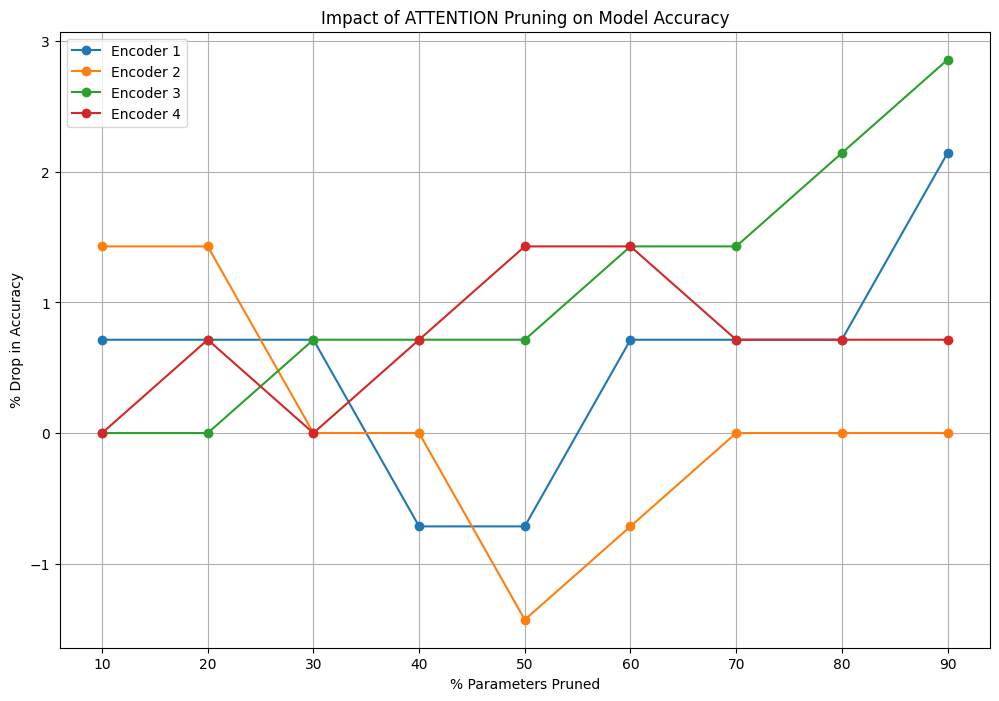

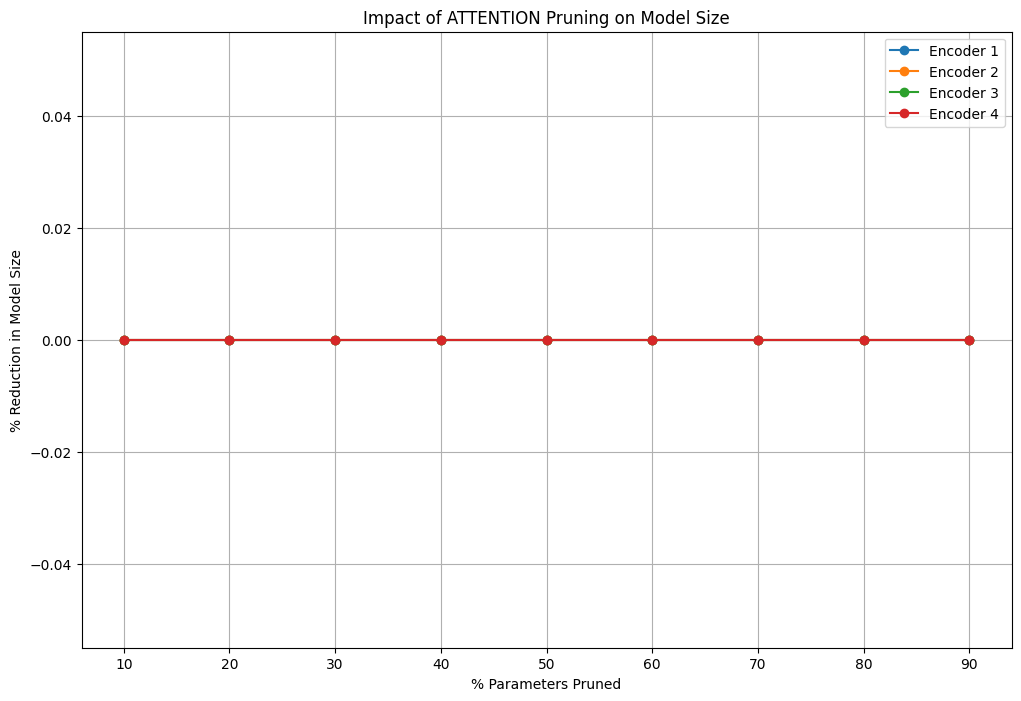

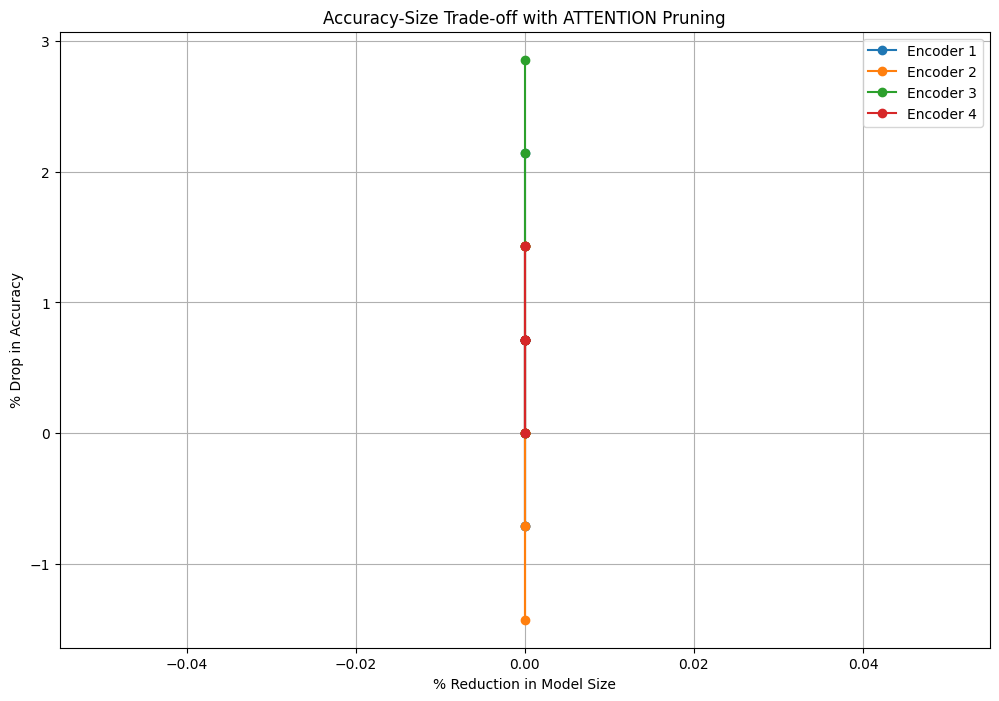

In [50]:
# Plot attention head pruning results
plot_sensitivity_scan(attention_results, model_alias, 'attention')

In [51]:
# Run sensitivity scan for FFN layers
print("\n=== Running FFN Pruning Sensitivity Scan ===")
ffn_results = run_sensitivity_scan(
    model_alias=model_alias,
    train_loader=train_loader,
    test_loader=test_loader,
    prune_type='ffn',
    encoder_indices=encoder_indices,
    prune_percentages=prune_percentages
)


=== Running FFN Pruning Sensitivity Scan ===


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline model - Accuracy: 0.9333, Size: 255.43 MB
Pruning ffn in encoder 1 by 10%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 1 by 20%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9400 (-0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 1 by 30%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9400 (-0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 1 by 40%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9467 (-1.43% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 1 by 50%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9400 (-0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 1 by 60%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 1 by 70%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9200 (1.43% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 1 by 80%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9133 (2.14% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 1 by 90%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9200 (1.43% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 2 by 10%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 2 by 20%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9200 (1.43% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 2 by 30%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 2 by 40%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9467 (-1.43% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 2 by 50%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9400 (-0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 2 by 60%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 2 by 70%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 2 by 80%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 2 by 90%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 3 by 10%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9400 (-0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 3 by 20%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9400 (-0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 3 by 30%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 3 by 40%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 3 by 50%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 3 by 60%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 3 by 70%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 3 by 80%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 3 by 90%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 4 by 10%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 4 by 20%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9200 (1.43% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 4 by 30%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 4 by 40%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 4 by 50%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 4 by 60%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9267 (0.71% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 4 by 70%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9200 (1.43% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 4 by 80%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9200 (1.43% drop), Size: 255.43 MB (0.00% reduction)
Pruning ffn in encoder 4 by 90%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Results - Accuracy: 0.9200 (1.43% drop), Size: 255.43 MB (0.00% reduction)


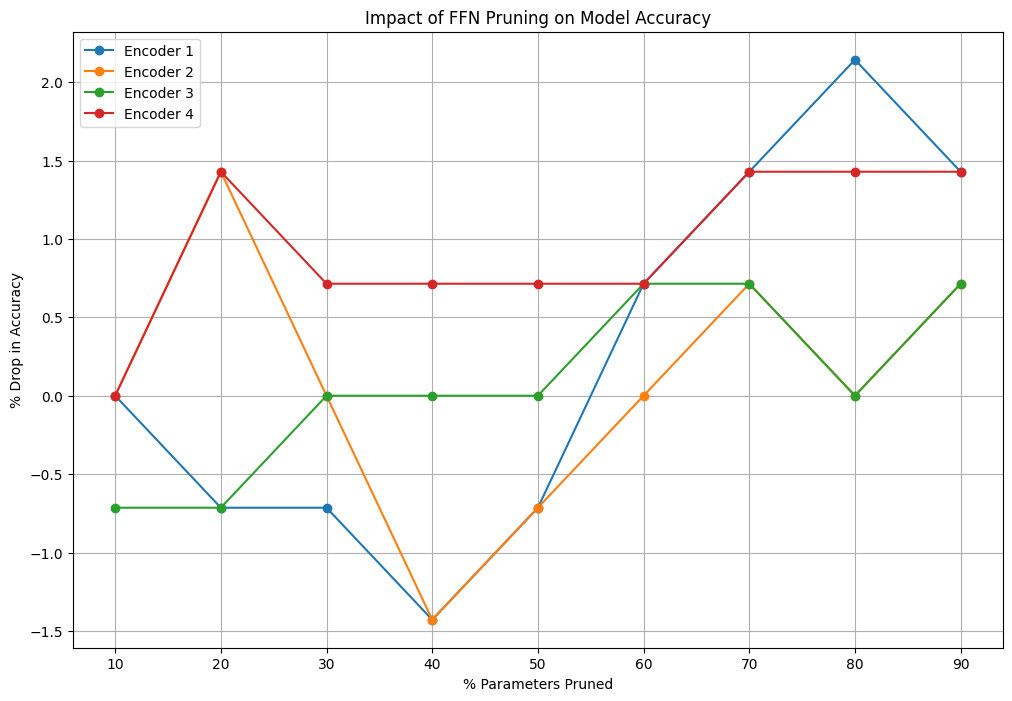

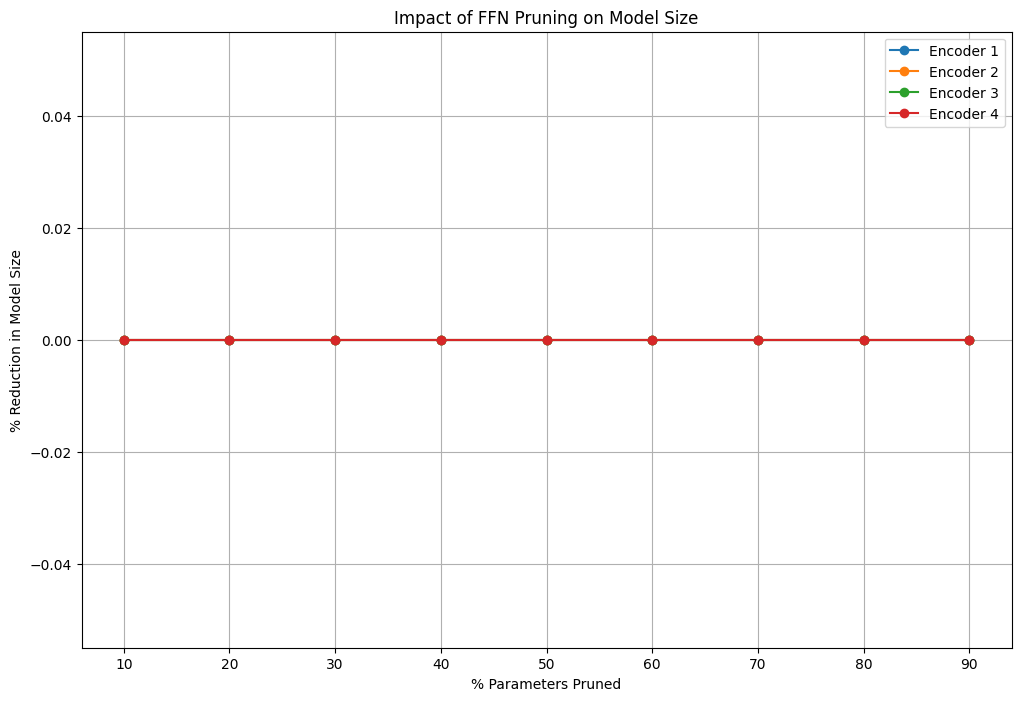

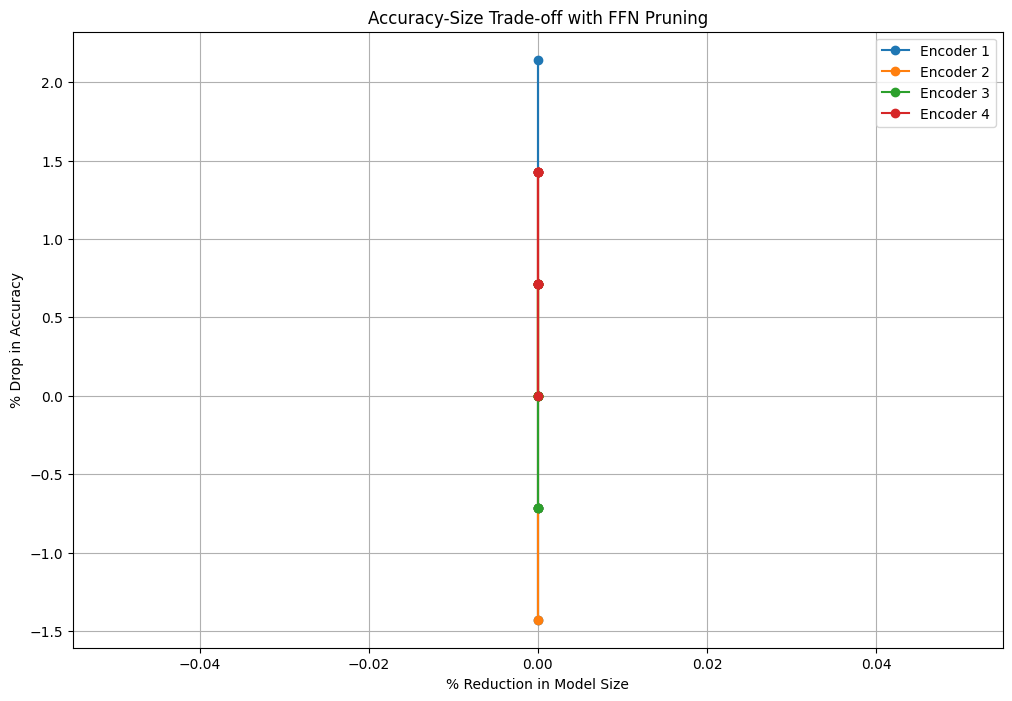

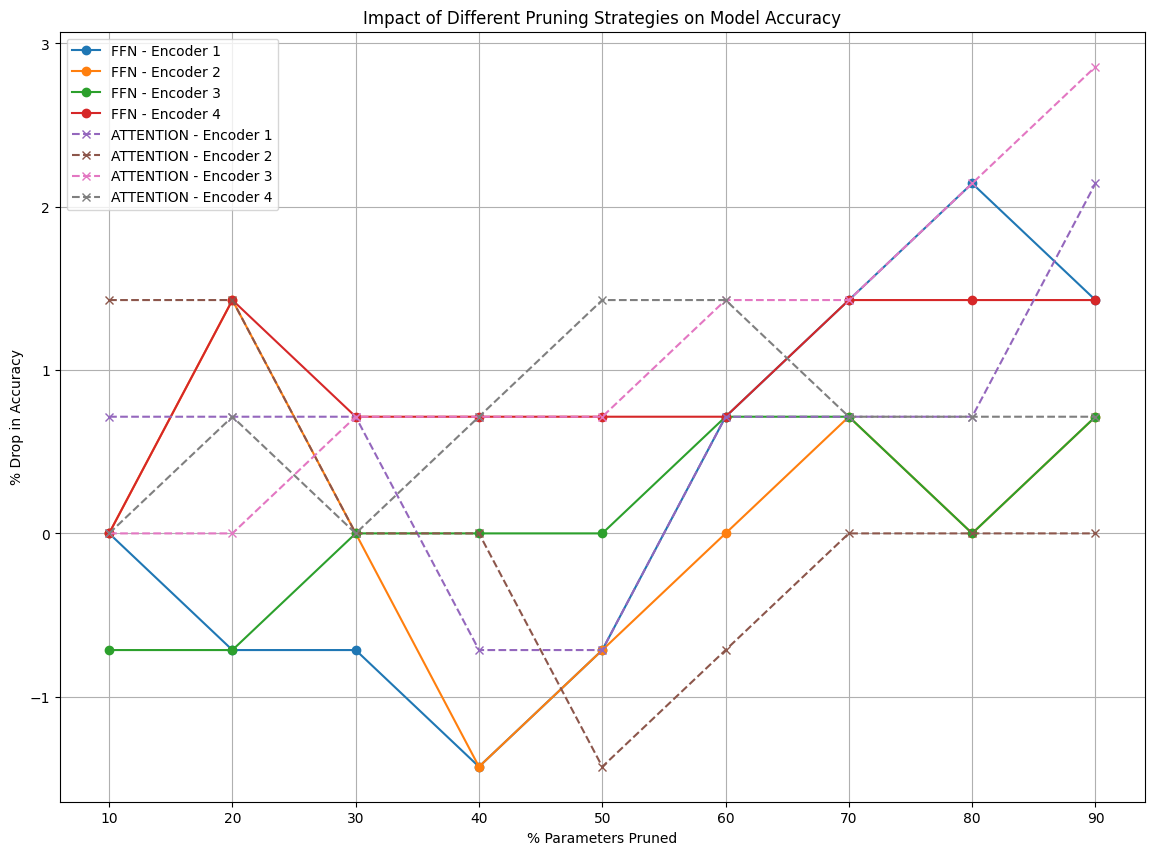

In [52]:

# Plot FFN pruning results
plot_sensitivity_scan(ffn_results, model_alias, 'ffn')

In [53]:
print("\n=== Creating Combined Visualization ===")
# Create a combined plot comparing all pruning strategies
plt.figure(figsize=(15, 10))


=== Creating Combined Visualization ===


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [55]:
model_dir = f"model-metric/{model_alias}"


Pruning analysis completed. Results saved to:
model-metric/distilbert-cased-lora/pruning/


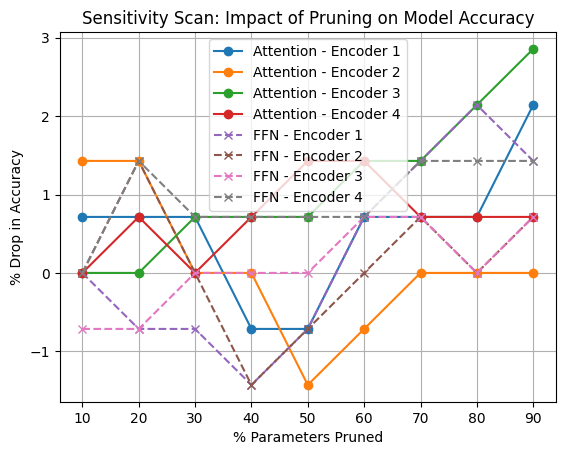

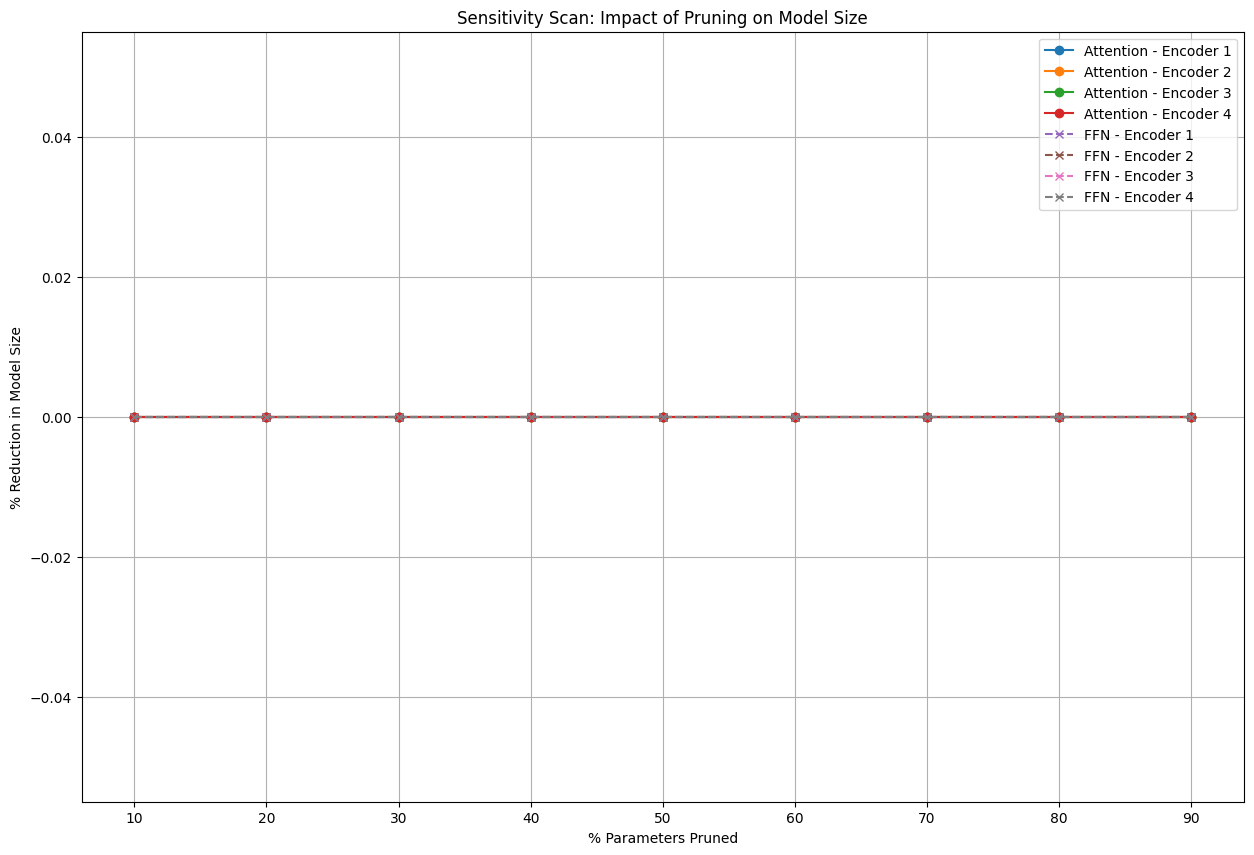

In [56]:
# Plot attention head pruning with solid lines
for encoder_idx in attention_results['encoder_index'].unique():
    if encoder_idx == 'baseline':
        continue
    subset = attention_results[attention_results['encoder_index'] == encoder_idx]
    plt.plot(subset['prune_percent'], subset['accuracy_drop_percent'], 
             marker='o', linestyle='-', 
             label=f'Attention - Encoder {encoder_idx}')

# Plot FFN pruning with dashed lines
for encoder_idx in ffn_results['encoder_index'].unique():
    if encoder_idx == 'baseline':
        continue
    subset = ffn_results[ffn_results['encoder_index'] == encoder_idx]
    plt.plot(subset['prune_percent'], subset['accuracy_drop_percent'], 
             marker='x', linestyle='--', 
             label=f'FFN - Encoder {encoder_idx}')

plt.title('Sensitivity Scan: Impact of Pruning on Model Accuracy')
plt.xlabel('% Parameters Pruned')
plt.ylabel('% Drop in Accuracy')
plt.grid(True)
plt.legend()
plt.savefig(f"{model_dir}/pruning/combined_sensitivity_scan.png", dpi=300)

# Plot comparing model size reduction
plt.figure(figsize=(15, 10))

# Plot attention head pruning
for encoder_idx in attention_results['encoder_index'].unique():
    if encoder_idx == 'baseline':
        continue
    subset = attention_results[attention_results['encoder_index'] == encoder_idx]
    plt.plot(subset['prune_percent'], subset['size_reduction_percent'], 
             marker='o', linestyle='-', 
             label=f'Attention - Encoder {encoder_idx}')

# Plot FFN pruning
for encoder_idx in ffn_results['encoder_index'].unique():
    if encoder_idx == 'baseline':
        continue
    subset = ffn_results[ffn_results['encoder_index'] == encoder_idx]
    plt.plot(subset['prune_percent'], subset['size_reduction_percent'], 
             marker='x', linestyle='--', 
             label=f'FFN - Encoder {encoder_idx}')

plt.title('Sensitivity Scan: Impact of Pruning on Model Size')
plt.xlabel('% Parameters Pruned')
plt.ylabel('% Reduction in Model Size')
plt.grid(True)
plt.legend()
plt.savefig(f"{model_dir}/pruning/combined_size_reduction.png", dpi=300)

print("\nPruning analysis completed. Results saved to:")
print(f"{model_dir}/pruning/")

In [57]:
def iterative_prune_and_finetune(model_alias, train_loader, test_loader, 
                              prune_type='attention', encoder_idx=2, 
                              prune_percentages=None, 
                              finetune_epochs=1, learning_rate=1e-5):
    """
    Iteratively prune the model and finetune after each pruning step.
    
    Args:
        model_alias: Name of the model
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        prune_type: 'attention' or 'ffn'
        encoder_idx: Index of encoder layer to prune
        prune_percentages: List of cumulative pruning percentages
        finetune_epochs: Number of epochs to finetune after each pruning
        learning_rate: Learning rate for finetuning
    
    Returns:
        DataFrame with pruning results
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if prune_percentages is None:
        prune_percentages = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
    
    results = []
    
    # Load original model to get baseline accuracy
    model, label_encoder = load_model_and_tokenizer(model_alias)
    model.to(device)
    baseline_accuracy = evaluate_accuracy(model, test_loader, device)
    baseline_size = get_model_size(model)
    
    print(f"Baseline model - Accuracy: {baseline_accuracy:.4f}, Size: {baseline_size:.2f} MB")
    
    # Store baseline for reference
    results.append({
        'prune_percent': 0,
        'accuracy': baseline_accuracy,
        'accuracy_drop_percent': 0.0,
        'model_size_mb': baseline_size,
        'size_reduction_percent': 0.0,
        'prune_type': 'none',
        'encoder_index': encoder_idx,
        'finetuned': False
    })
    
    # Iteratively prune and finetune
    prev_prune_percent = 0
    current_model = model
    
    for prune_percent in prune_percentages:
        if prune_percent == 0:
            continue
        
        # Calculate incremental pruning percentage
        incremental_percent = prune_percent - prev_prune_percent
        if incremental_percent <= 0:
            continue
            
        print(f"Pruning {prune_type} in encoder {encoder_idx} by additional {incremental_percent}% (total {prune_percent}%)")
        
        # Apply pruning
        if prune_type == 'attention':
            current_model = prune_attention_heads(current_model, encoder_idx, incremental_percent)
        elif prune_type == 'ffn':
            current_model = prune_ffn(current_model, encoder_idx, incremental_percent)
        
        # Evaluate before finetuning
        pre_finetune_accuracy = evaluate_accuracy(current_model, test_loader, device)
        model_size = get_model_size(current_model)
        
        # Calculate metrics
        accuracy_drop = baseline_accuracy - pre_finetune_accuracy
        accuracy_drop_percent = (accuracy_drop / baseline_accuracy) * 100
        size_reduction = baseline_size - model_size
        size_reduction_percent = (size_reduction / baseline_size) * 100
        
        print(f"Before finetuning - Accuracy: {pre_finetune_accuracy:.4f} ({accuracy_drop_percent:.2f}% drop), "
              f"Size: {model_size:.2f} MB ({size_reduction_percent:.2f}% reduction)")
        
        # Store pre-finetuning results
        results.append({
            'prune_percent': prune_percent,
            'accuracy': pre_finetune_accuracy,
            'accuracy_drop_percent': accuracy_drop_percent,
            'model_size_mb': model_size,
            'size_reduction_percent': size_reduction_percent,
            'prune_type': prune_type,
            'encoder_index': encoder_idx,
            'finetuned': False
        })
        
        # Finetune the model
        if finetune_epochs > 0:
            print(f"Finetuning for {finetune_epochs} epochs...")
            optimizer = optim.AdamW(current_model.parameters(), lr=learning_rate)
            criterion = nn.CrossEntropyLoss()
            
            current_model.train()
            for epoch in range(finetune_epochs):
                total_loss = 0
                for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{finetune_epochs}"):
                    input_ids, attention_mask, labels = [x.to(device) for x in batch]
                    
                    optimizer.zero_grad()
                    outputs = current_model(input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    
                    total_loss += loss.item()
                
                avg_loss = total_loss / len(train_loader)
                print(f"Epoch {epoch+1}: Average Loss = {avg_loss:.4f}")
            
            # Evaluate after finetuning
            current_model.eval()
            post_finetune_accuracy = evaluate_accuracy(current_model, test_loader, device)
            
            # Calculate post-finetuning metrics
            accuracy_drop = baseline_accuracy - post_finetune_accuracy
            accuracy_drop_percent = (accuracy_drop / baseline_accuracy) * 100
            
            print(f"After finetuning - Accuracy: {post_finetune_accuracy:.4f} ({accuracy_drop_percent:.2f}% drop)")
            
            # Store post-finetuning results
            results.append({
                'prune_percent': prune_percent,
                'accuracy': post_finetune_accuracy,
                'accuracy_drop_percent': accuracy_drop_percent,
                'model_size_mb': model_size,
                'size_reduction_percent': size_reduction_percent,
                'prune_type': prune_type,
                'encoder_index': encoder_idx,
                'finetuned': True
            })
        
        # Update for next iteration
        prev_prune_percent = prune_percent
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Save results
    os.makedirs(f"model-metric/{model_alias}/pruning", exist_ok=True)
    results_df.to_csv(f"model-metric/{model_alias}/pruning/{prune_type}_iterative_encoder{encoder_idx}.csv", index=False)
    
    return results_df, current_model

In [58]:
def plot_iterative_pruning_results(results_df, model_alias, prune_type, encoder_idx):
    """
    Plot the iterative pruning results.
    
    Args:
        results_df: DataFrame with pruning results
        model_alias: Name of the model
        prune_type: 'attention' or 'ffn'
        encoder_idx: Index of encoder layer pruned
    """
    # Create output directory
    os.makedirs(f"model-metric/{model_alias}/pruning", exist_ok=True)
    
    # Split results into pre-finetuning and post-finetuning
    pre_finetune = results_df[results_df['finetuned'] == False]
    post_finetune = results_df[results_df['finetuned'] == True]
    
    # Plot 1: Accuracy drop vs pruning percentage
    plt.figure(figsize=(12, 8))
    plt.plot(pre_finetune['prune_percent'], pre_finetune['accuracy_drop_percent'], 
             marker='o', linestyle='-', label='Before Finetuning')
    
    if not post_finetune.empty:
        plt.plot(post_finetune['prune_percent'], post_finetune['accuracy_drop_percent'], 
                 marker='x', linestyle='--', label='After Finetuning')
    
    plt.title(f'Impact of Iterative {prune_type.upper()} Pruning on Encoder {encoder_idx}')
    plt.xlabel('% Parameters Pruned (Cumulative)')
    plt.ylabel('% Drop in Accuracy')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"model-metric/{model_alias}/pruning/{prune_type}_iterative_encoder{encoder_idx}_accuracy.png", dpi=300)
    
    # Plot 2: Accuracy vs model size reduction
    plt.figure(figsize=(12, 8))
    plt.plot(pre_finetune['size_reduction_percent'], pre_finetune['accuracy_drop_percent'], 
             marker='o', linestyle='-', label='Before Finetuning')
    
    if not post_finetune.empty:
        plt.plot(post_finetune['size_reduction_percent'], post_finetune['accuracy_drop_percent'], 
                 marker='x', linestyle='--', label='After Finetuning')
    
    plt.title(f'Accuracy-Size Trade-off with Iterative {prune_type.upper()} Pruning on Encoder {encoder_idx}')
    plt.xlabel('% Reduction in Model Size')
    plt.ylabel('% Drop in Accuracy')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"model-metric/{model_alias}/pruning/{prune_type}_iterative_encoder{encoder_idx}_tradeoff.png", dpi=300)
    
    return

    

In [59]:
def run_iterative_pruning_experiment(model_alias, train_loader, test_loader):
    """
    Run iterative pruning experiments on different encoder layers.
    
    Args:
        model_alias: Name of the model
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
    """
    # Define parameters
    encoder_indices = [2, 3, 4]  # Choose a few encoders to test
    prune_types = ['attention', 'ffn']
    prune_percentages = [0, 20, 40, 60, 80, 90]  # Cumulative percentages
    finetune_epochs = 2
    
    all_results = []
    
    for prune_type in prune_types:
        for encoder_idx in encoder_indices:
            print(f"\n=== Running Iterative {prune_type.upper()} Pruning on Encoder {encoder_idx} ===")
            
            # Run iterative pruning
            results_df, pruned_model = iterative_prune_and_finetune(
                model_alias=model_alias,
                train_loader=train_loader,
                test_loader=test_loader,
                prune_type=prune_type,
                encoder_idx=encoder_idx,
                prune_percentages=prune_percentages,
                finetune_epochs=finetune_epochs
            )
            
            # Plot results
            plot_iterative_pruning_results(results_df, model_alias, prune_type, encoder_idx)
            
            # Save pruned model
            if pruned_model is not None:
                pruned_model_path = f"model-metric/{model_alias}/pruning/{prune_type}_pruned_encoder{encoder_idx}.pth"
                torch.save(pruned_model.state_dict(), pruned_model_path)
                print(f"Saved pruned model to {pruned_model_path}")
            
            # Save results for combined analysis
            all_results.append({
                'prune_type': prune_type,
                'encoder_idx': encoder_idx,
                'results': results_df
            })
    
    # Create combined visualization
    create_combined_iterative_visualization(model_alias, all_results)
    
    return all_results

    

In [60]:
def create_combined_iterative_visualization(model_alias, all_results):
    """
    Create a combined visualization of all iterative pruning experiments.
    
    Args:
        model_alias: Name of the model
        all_results: List of dictionaries with pruning results
    """
    plt.figure(figsize=(15, 10))
    
    for result_dict in all_results:
        prune_type = result_dict['prune_type']
        encoder_idx = result_dict['encoder_idx']
        results_df = result_dict['results']
        
        # Get only the finetuned results
        finetuned = results_df[results_df['finetuned'] == True]
        if finetuned.empty:
            finetuned = results_df  # Use all results if no finetuned ones
        
        linestyle = '-' if prune_type == 'attention' else '--'
        plt.plot(finetuned['prune_percent'], finetuned['accuracy_drop_percent'], 
                 marker='o' if prune_type == 'attention' else 'x', 
                 linestyle=linestyle,
                 label=f'{prune_type.upper()} - Encoder {encoder_idx}')
    
    plt.title('Comparison of Iterative Pruning Strategies')
    plt.xlabel('% Parameters Pruned (Cumulative)')
    plt.ylabel('% Drop in Accuracy')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"model-metric/{model_alias}/pruning/combined_iterative_pruning.png", dpi=300)



In [64]:
from tqdm import tqdm


=== Running Iterative Pruning with Fine-tuning ===

=== Running Iterative ATTENTION Pruning on Encoder 2 ===


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline model - Accuracy: 0.9333, Size: 255.43 MB
Pruning attention in encoder 2 by additional 20% (total 20%)
Before finetuning - Accuracy: 0.9200 (1.43% drop), Size: 255.43 MB (0.00% reduction)
Finetuning for 2 epochs...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...0/57 [00:00<?, ?it/s]
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 1/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [02:48<00:00,  2.96s/it]


Epoch 1: Average Loss = 0.0144


Epoch 2/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [03:04<00:00,  3.23s/it]


Epoch 2: Average Loss = 0.0068
After finetuning - Accuracy: 0.9533 (-2.14% drop)
Pruning attention in encoder 2 by additional 20% (total 40%)
Before finetuning - Accuracy: 0.9533 (-2.14% drop), Size: 255.43 MB (0.00% reduction)
Finetuning for 2 epochs...


Epoch 1/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [02:49<00:00,  2.97s/it]


Epoch 1: Average Loss = 0.0035


Epoch 2/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [02:45<00:00,  2.91s/it]


Epoch 2: Average Loss = 0.0016
After finetuning - Accuracy: 0.9600 (-2.86% drop)
Pruning attention in encoder 2 by additional 20% (total 60%)
Before finetuning - Accuracy: 0.9600 (-2.86% drop), Size: 255.43 MB (0.00% reduction)
Finetuning for 2 epochs...


Epoch 1/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [02:45<00:00,  2.91s/it]


Epoch 1: Average Loss = 0.0008


Epoch 2/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [02:47<00:00,  2.94s/it]


Epoch 2: Average Loss = 0.0004
After finetuning - Accuracy: 0.9533 (-2.14% drop)
Pruning attention in encoder 2 by additional 20% (total 80%)
Before finetuning - Accuracy: 0.9533 (-2.14% drop), Size: 255.43 MB (0.00% reduction)
Finetuning for 2 epochs...


Epoch 1/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [02:40<00:00,  2.82s/it]


Epoch 1: Average Loss = 0.0002


Epoch 2/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [02:48<00:00,  2.95s/it]


Epoch 2: Average Loss = 0.0001
After finetuning - Accuracy: 0.9533 (-2.14% drop)
Pruning attention in encoder 2 by additional 10% (total 90%)
Before finetuning - Accuracy: 0.9533 (-2.14% drop), Size: 255.43 MB (0.00% reduction)
Finetuning for 2 epochs...


Epoch 1/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [02:55<00:00,  3.08s/it]


Epoch 1: Average Loss = 0.0000


Epoch 2/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [03:36<00:00,  3.80s/it]


Epoch 2: Average Loss = 0.0000
After finetuning - Accuracy: 0.9533 (-2.14% drop)
Saved pruned model to model-metric/distilbert-cased-lora/pruning/attention_pruned_encoder2.pth

=== Running Iterative ATTENTION Pruning on Encoder 3 ===


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline model - Accuracy: 0.9333, Size: 255.43 MB
Pruning attention in encoder 3 by additional 20% (total 20%)
Before finetuning - Accuracy: 0.9333 (0.00% drop), Size: 255.43 MB (0.00% reduction)
Finetuning for 2 epochs...


Epoch 1/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [03:33<00:00,  3.74s/it]


Epoch 1: Average Loss = 0.0123


Epoch 2/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [03:43<00:00,  3.92s/it]


Epoch 2: Average Loss = 0.0058
After finetuning - Accuracy: 0.9533 (-2.14% drop)
Pruning attention in encoder 3 by additional 20% (total 40%)
Before finetuning - Accuracy: 0.9533 (-2.14% drop), Size: 255.43 MB (0.00% reduction)
Finetuning for 2 epochs...


Epoch 1/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [03:38<00:00,  3.83s/it]


Epoch 1: Average Loss = 0.0029


Epoch 2/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [03:43<00:00,  3.92s/it]


Epoch 2: Average Loss = 0.0013
After finetuning - Accuracy: 0.9533 (-2.14% drop)
Pruning attention in encoder 3 by additional 20% (total 60%)
Before finetuning - Accuracy: 0.9533 (-2.14% drop), Size: 255.43 MB (0.00% reduction)
Finetuning for 2 epochs...


Epoch 1/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [03:43<00:00,  3.91s/it]


Epoch 1: Average Loss = 0.0007


Epoch 2/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [03:40<00:00,  3.87s/it]


Epoch 2: Average Loss = 0.0003
After finetuning - Accuracy: 0.9600 (-2.86% drop)
Pruning attention in encoder 3 by additional 20% (total 80%)
Before finetuning - Accuracy: 0.9600 (-2.86% drop), Size: 255.43 MB (0.00% reduction)
Finetuning for 2 epochs...


Epoch 1/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [03:44<00:00,  3.94s/it]


Epoch 1: Average Loss = 0.0001


Epoch 2/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [03:32<00:00,  3.73s/it]


Epoch 2: Average Loss = 0.0001
After finetuning - Accuracy: 0.9600 (-2.86% drop)
Pruning attention in encoder 3 by additional 10% (total 90%)
Before finetuning - Accuracy: 0.9600 (-2.86% drop), Size: 255.43 MB (0.00% reduction)
Finetuning for 2 epochs...


Epoch 1/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [02:14<00:00,  2.36s/it]


Epoch 1: Average Loss = 0.0000


Epoch 2/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [02:11<00:00,  2.30s/it]


Epoch 2: Average Loss = 0.0000
After finetuning - Accuracy: 0.9533 (-2.14% drop)
Saved pruned model to model-metric/distilbert-cased-lora/pruning/attention_pruned_encoder3.pth

=== Running Iterative ATTENTION Pruning on Encoder 4 ===


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: Error(s) in loading state_dict for DistilBERTWithLoRA:
	Missing key(s) in state_dict: "bert.distilbert.embeddings.word_embeddings.weight", "bert.distilbert.embeddings.position_embeddings.weight", "bert.distilbert.embeddings.LayerNorm.weight", "bert.distilbert.embeddings.LayerNorm.bias", "bert.distilbert.transformer.layer.0.attention.q_lin.weight", "bert.distilbert.transformer.layer.0.attention.q_lin.bias", "bert.distilbert.transformer.layer.0.attention.k_lin.weight", "bert.distilbert.transformer.layer.0.attention.k_lin.bias", "bert.distilbert.transformer.layer.0.attention.v_lin.weight", "bert.distilbert.transformer.layer.0.attention.v_lin.bias", "bert.distilbert.transformer.layer.0.attention.out_lin.weight", "bert.distilbert.transformer.layer.0.attention.out_lin.bias", "bert.distilbert.transformer.layer.0.sa_layer_norm.weight", "bert.distilbert.transformer.layer.0.sa_layer_norm.bias", "bert.distilbert.transformer.layer.0.ffn.lin1.weight", "bert.distilbert.transformer.layer.0.ffn.lin1.bias", "bert.distilbert.transformer.layer.0.ffn.lin2.weight", "bert.distilbert.transformer.layer.0.ffn.lin2.bias", "bert.distilbert.transformer.layer.0.output_layer_norm.weight", "bert.distilbert.transformer.layer.0.output_layer_norm.bias", "bert.distilbert.transformer.layer.1.attention.q_lin.weight", "bert.distilbert.transformer.layer.1.attention.q_lin.bias", "bert.distilbert.transformer.layer.1.attention.k_lin.weight", "bert.distilbert.transformer.layer.1.attention.k_lin.bias", "bert.distilbert.transformer.layer.1.attention.v_lin.weight", "bert.distilbert.transformer.layer.1.attention.v_lin.bias", "bert.distilbert.transformer.layer.1.attention.out_lin.weight", "bert.distilbert.transformer.layer.1.attention.out_lin.bias", "bert.distilbert.transformer.layer.1.sa_layer_norm.weight", "bert.distilbert.transformer.layer.1.sa_layer_norm.bias", "bert.distilbert.transformer.layer.1.ffn.lin1.weight", "bert.distilbert.transformer.layer.1.ffn.lin1.bias", "bert.distilbert.transformer.layer.1.ffn.lin2.weight", "bert.distilbert.transformer.layer.1.ffn.lin2.bias", "bert.distilbert.transformer.layer.1.output_layer_norm.weight", "bert.distilbert.transformer.layer.1.output_layer_norm.bias", "bert.distilbert.transformer.layer.2.attention.q_lin.weight", "bert.distilbert.transformer.layer.2.attention.q_lin.bias", "bert.distilbert.transformer.layer.2.attention.k_lin.weight", "bert.distilbert.transformer.layer.2.attention.k_lin.bias", "bert.distilbert.transformer.layer.2.attention.v_lin.weight", "bert.distilbert.transformer.layer.2.attention.v_lin.bias", "bert.distilbert.transformer.layer.2.attention.out_lin.weight", "bert.distilbert.transformer.layer.2.attention.out_lin.bias", "bert.distilbert.transformer.layer.2.sa_layer_norm.weight", "bert.distilbert.transformer.layer.2.sa_layer_norm.bias", "bert.distilbert.transformer.layer.2.ffn.lin1.weight", "bert.distilbert.transformer.layer.2.ffn.lin1.bias", "bert.distilbert.transformer.layer.2.ffn.lin2.weight", "bert.distilbert.transformer.layer.2.ffn.lin2.bias", "bert.distilbert.transformer.layer.2.output_layer_norm.weight", "bert.distilbert.transformer.layer.2.output_layer_norm.bias", "bert.distilbert.transformer.layer.3.attention.q_lin.weight", "bert.distilbert.transformer.layer.3.attention.q_lin.bias", "bert.distilbert.transformer.layer.3.attention.k_lin.weight", "bert.distilbert.transformer.layer.3.attention.k_lin.bias", "bert.distilbert.transformer.layer.3.attention.v_lin.weight", "bert.distilbert.transformer.layer.3.attention.v_lin.bias", "bert.distilbert.transformer.layer.3.attention.out_lin.weight", "bert.distilbert.transformer.layer.3.attention.out_lin.bias", "bert.distilbert.transformer.layer.3.sa_layer_norm.weight", "bert.distilbert.transformer.layer.3.sa_layer_norm.bias", "bert.distilbert.transformer.layer.3.ffn.lin1.weight", "bert.distilbert.transformer.layer.3.ffn.lin1.bias", "bert.distilbert.transformer.layer.3.ffn.lin2.weight", "bert.distilbert.transformer.layer.3.ffn.lin2.bias", "bert.distilbert.transformer.layer.3.output_layer_norm.weight", "bert.distilbert.transformer.layer.3.output_layer_norm.bias", "bert.distilbert.transformer.layer.4.attention.q_lin.weight", "bert.distilbert.transformer.layer.4.attention.q_lin.bias", "bert.distilbert.transformer.layer.4.attention.k_lin.weight", "bert.distilbert.transformer.layer.4.attention.k_lin.bias", "bert.distilbert.transformer.layer.4.attention.v_lin.weight", "bert.distilbert.transformer.layer.4.attention.v_lin.bias", "bert.distilbert.transformer.layer.4.attention.out_lin.weight", "bert.distilbert.transformer.layer.4.attention.out_lin.bias", "bert.distilbert.transformer.layer.4.sa_layer_norm.weight", "bert.distilbert.transformer.layer.4.sa_layer_norm.bias", "bert.distilbert.transformer.layer.4.ffn.lin1.weight", "bert.distilbert.transformer.layer.4.ffn.lin1.bias", "bert.distilbert.transformer.layer.4.ffn.lin2.weight", "bert.distilbert.transformer.layer.4.ffn.lin2.bias", "bert.distilbert.transformer.layer.4.output_layer_norm.weight", "bert.distilbert.transformer.layer.4.output_layer_norm.bias", "bert.distilbert.transformer.layer.5.attention.q_lin.weight", "bert.distilbert.transformer.layer.5.attention.q_lin.bias", "bert.distilbert.transformer.layer.5.attention.k_lin.weight", "bert.distilbert.transformer.layer.5.attention.k_lin.bias", "bert.distilbert.transformer.layer.5.attention.v_lin.weight", "bert.distilbert.transformer.layer.5.attention.v_lin.bias", "bert.distilbert.transformer.layer.5.attention.out_lin.weight", "bert.distilbert.transformer.layer.5.attention.out_lin.bias", "bert.distilbert.transformer.layer.5.sa_layer_norm.weight", "bert.distilbert.transformer.layer.5.sa_layer_norm.bias", "bert.distilbert.transformer.layer.5.ffn.lin1.weight", "bert.distilbert.transformer.layer.5.ffn.lin1.bias", "bert.distilbert.transformer.layer.5.ffn.lin2.weight", "bert.distilbert.transformer.layer.5.ffn.lin2.bias", "bert.distilbert.transformer.layer.5.output_layer_norm.weight", "bert.distilbert.transformer.layer.5.output_layer_norm.bias", "bert.pre_classifier.weight", "bert.pre_classifier.bias", "bert.classifier.weight", "bert.classifier.bias". 
	Unexpected key(s) in state_dict: "bert.base_model.model.distilbert.embeddings.word_embeddings.weight", "bert.base_model.model.distilbert.embeddings.position_embeddings.weight", "bert.base_model.model.distilbert.embeddings.LayerNorm.weight", "bert.base_model.model.distilbert.embeddings.LayerNorm.bias", "bert.base_model.model.distilbert.transformer.layer.0.attention.q_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.0.attention.q_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.0.attention.q_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.0.attention.q_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.0.attention.k_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.0.attention.k_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.0.attention.k_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.0.attention.k_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.0.attention.v_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.0.attention.v_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.0.attention.v_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.0.attention.v_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.0.attention.out_lin.weight", "bert.base_model.model.distilbert.transformer.layer.0.attention.out_lin.bias", "bert.base_model.model.distilbert.transformer.layer.0.sa_layer_norm.weight", "bert.base_model.model.distilbert.transformer.layer.0.sa_layer_norm.bias", "bert.base_model.model.distilbert.transformer.layer.0.ffn.lin1.weight", "bert.base_model.model.distilbert.transformer.layer.0.ffn.lin1.bias", "bert.base_model.model.distilbert.transformer.layer.0.ffn.lin2.weight", "bert.base_model.model.distilbert.transformer.layer.0.ffn.lin2.bias", "bert.base_model.model.distilbert.transformer.layer.0.output_layer_norm.weight", "bert.base_model.model.distilbert.transformer.layer.0.output_layer_norm.bias", "bert.base_model.model.distilbert.transformer.layer.1.attention.q_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.1.attention.q_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.1.attention.q_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.1.attention.q_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.1.attention.k_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.1.attention.k_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.1.attention.k_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.1.attention.k_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.1.attention.v_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.1.attention.v_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.1.attention.v_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.1.attention.v_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.1.attention.out_lin.weight", "bert.base_model.model.distilbert.transformer.layer.1.attention.out_lin.bias", "bert.base_model.model.distilbert.transformer.layer.1.sa_layer_norm.weight", "bert.base_model.model.distilbert.transformer.layer.1.sa_layer_norm.bias", "bert.base_model.model.distilbert.transformer.layer.1.ffn.lin1.weight", "bert.base_model.model.distilbert.transformer.layer.1.ffn.lin1.bias", "bert.base_model.model.distilbert.transformer.layer.1.ffn.lin2.weight", "bert.base_model.model.distilbert.transformer.layer.1.ffn.lin2.bias", "bert.base_model.model.distilbert.transformer.layer.1.output_layer_norm.weight", "bert.base_model.model.distilbert.transformer.layer.1.output_layer_norm.bias", "bert.base_model.model.distilbert.transformer.layer.2.attention.q_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.2.attention.q_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.2.attention.q_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.2.attention.q_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.2.attention.k_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.2.attention.k_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.2.attention.k_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.2.attention.k_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.2.attention.v_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.2.attention.v_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.2.attention.v_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.2.attention.v_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.2.attention.out_lin.weight", "bert.base_model.model.distilbert.transformer.layer.2.attention.out_lin.bias", "bert.base_model.model.distilbert.transformer.layer.2.sa_layer_norm.weight", "bert.base_model.model.distilbert.transformer.layer.2.sa_layer_norm.bias", "bert.base_model.model.distilbert.transformer.layer.2.ffn.lin1.weight", "bert.base_model.model.distilbert.transformer.layer.2.ffn.lin1.bias", "bert.base_model.model.distilbert.transformer.layer.2.ffn.lin2.weight", "bert.base_model.model.distilbert.transformer.layer.2.ffn.lin2.bias", "bert.base_model.model.distilbert.transformer.layer.2.output_layer_norm.weight", "bert.base_model.model.distilbert.transformer.layer.2.output_layer_norm.bias", "bert.base_model.model.distilbert.transformer.layer.3.attention.q_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.3.attention.q_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.3.attention.q_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.3.attention.q_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.3.attention.k_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.3.attention.k_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.3.attention.k_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.3.attention.k_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.3.attention.v_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.3.attention.v_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.3.attention.v_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.3.attention.v_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.3.attention.out_lin.weight", "bert.base_model.model.distilbert.transformer.layer.3.attention.out_lin.bias", "bert.base_model.model.distilbert.transformer.layer.3.sa_layer_norm.weight", "bert.base_model.model.distilbert.transformer.layer.3.sa_layer_norm.bias", "bert.base_model.model.distilbert.transformer.layer.3.ffn.lin1.weight", "bert.base_model.model.distilbert.transformer.layer.3.ffn.lin1.bias", "bert.base_model.model.distilbert.transformer.layer.3.ffn.lin2.weight", "bert.base_model.model.distilbert.transformer.layer.3.ffn.lin2.bias", "bert.base_model.model.distilbert.transformer.layer.3.output_layer_norm.weight", "bert.base_model.model.distilbert.transformer.layer.3.output_layer_norm.bias", "bert.base_model.model.distilbert.transformer.layer.4.attention.q_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.4.attention.q_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.4.attention.q_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.4.attention.q_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.4.attention.k_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.4.attention.k_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.4.attention.k_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.4.attention.k_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.4.attention.v_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.4.attention.v_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.4.attention.v_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.4.attention.v_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.4.attention.out_lin.weight", "bert.base_model.model.distilbert.transformer.layer.4.attention.out_lin.bias", "bert.base_model.model.distilbert.transformer.layer.4.sa_layer_norm.weight", "bert.base_model.model.distilbert.transformer.layer.4.sa_layer_norm.bias", "bert.base_model.model.distilbert.transformer.layer.4.ffn.lin1.weight", "bert.base_model.model.distilbert.transformer.layer.4.ffn.lin1.bias", "bert.base_model.model.distilbert.transformer.layer.4.ffn.lin2.weight", "bert.base_model.model.distilbert.transformer.layer.4.ffn.lin2.bias", "bert.base_model.model.distilbert.transformer.layer.4.output_layer_norm.weight", "bert.base_model.model.distilbert.transformer.layer.4.output_layer_norm.bias", "bert.base_model.model.distilbert.transformer.layer.5.attention.q_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.5.attention.q_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.5.attention.q_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.5.attention.q_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.5.attention.k_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.5.attention.k_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.5.attention.k_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.5.attention.k_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.5.attention.v_lin.base_layer.weight", "bert.base_model.model.distilbert.transformer.layer.5.attention.v_lin.base_layer.bias", "bert.base_model.model.distilbert.transformer.layer.5.attention.v_lin.lora_A.default.weight", "bert.base_model.model.distilbert.transformer.layer.5.attention.v_lin.lora_B.default.weight", "bert.base_model.model.distilbert.transformer.layer.5.attention.out_lin.weight", "bert.base_model.model.distilbert.transformer.layer.5.attention.out_lin.bias", "bert.base_model.model.distilbert.transformer.layer.5.sa_layer_norm.weight", "bert.base_model.model.distilbert.transformer.layer.5.sa_layer_norm.bias", "bert.base_model.model.distilbert.transformer.layer.5.ffn.lin1.weight", "bert.base_model.model.distilbert.transformer.layer.5.ffn.lin1.bias", "bert.base_model.model.distilbert.transformer.layer.5.ffn.lin2.weight", "bert.base_model.model.distilbert.transformer.layer.5.ffn.lin2.bias", "bert.base_model.model.distilbert.transformer.layer.5.output_layer_norm.weight", "bert.base_model.model.distilbert.transformer.layer.5.output_layer_norm.bias", "bert.base_model.model.pre_classifier.original_module.weight", "bert.base_model.model.pre_classifier.original_module.bias", "bert.base_model.model.pre_classifier.modules_to_save.default.weight", "bert.base_model.model.pre_classifier.modules_to_save.default.bias", "bert.base_model.model.classifier.original_module.weight", "bert.base_model.model.classifier.original_module.bias", "bert.base_model.model.classifier.modules_to_save.default.weight", "bert.base_model.model.classifier.modules_to_save.default.bias". 

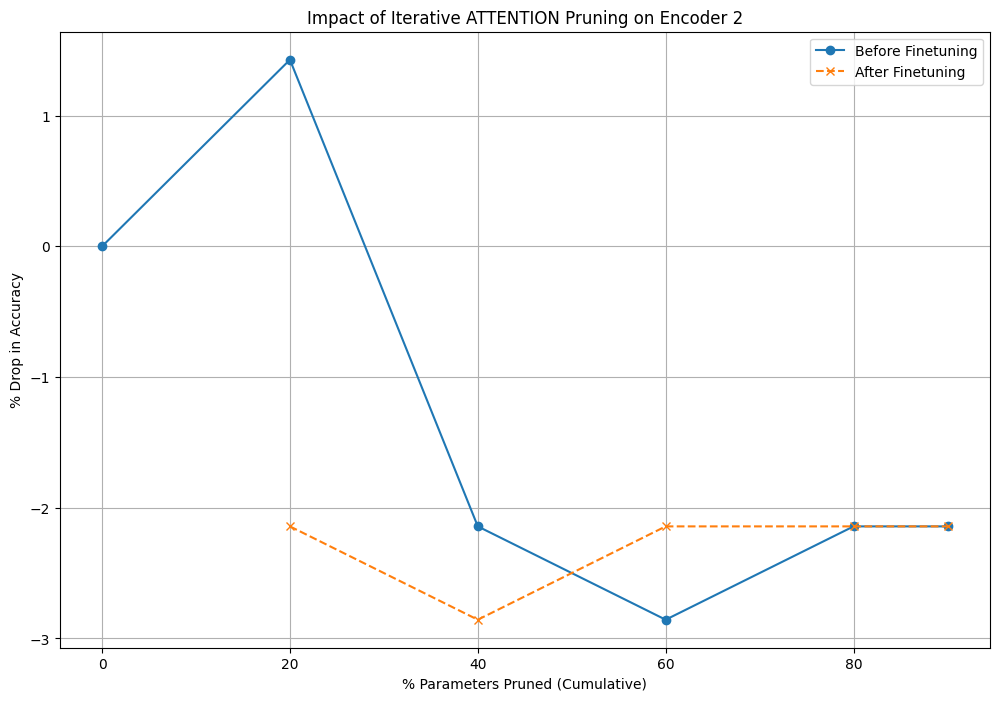

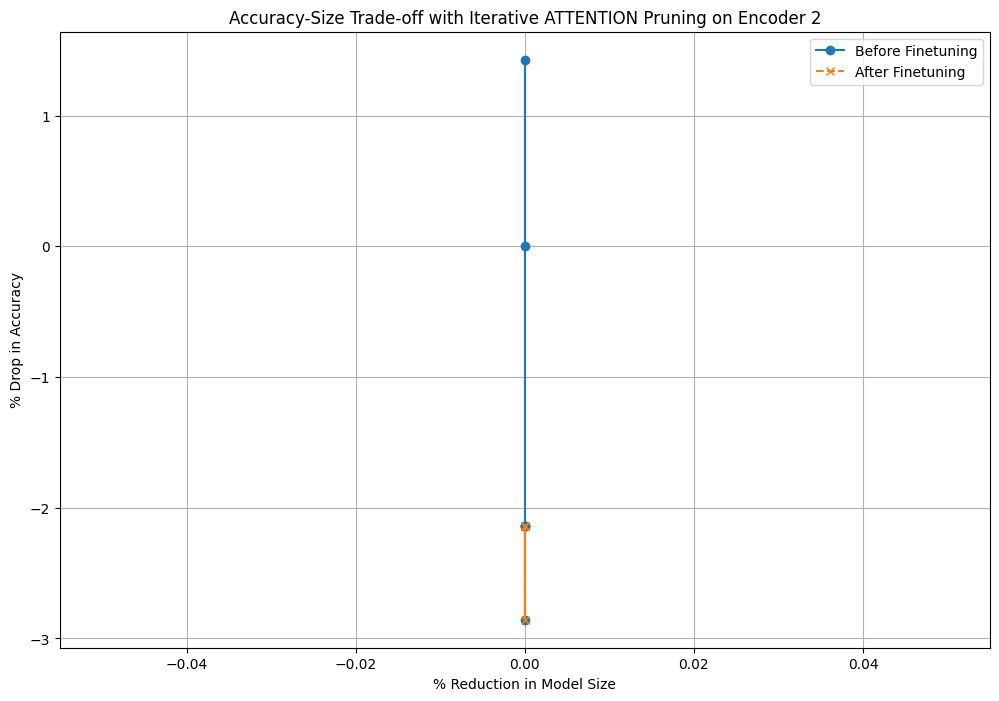

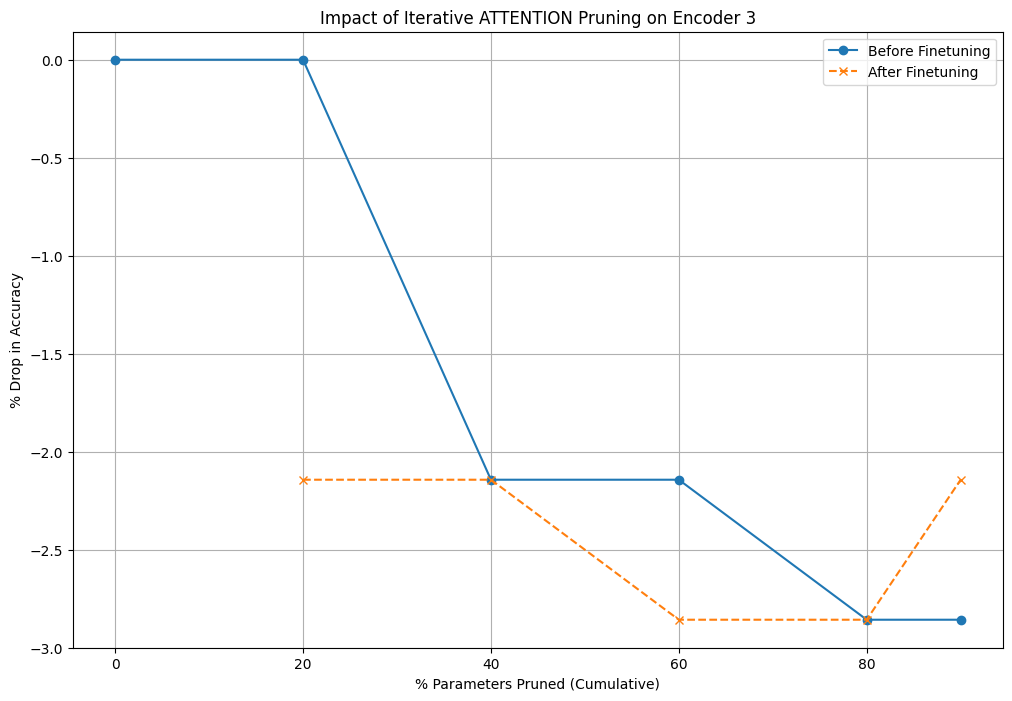

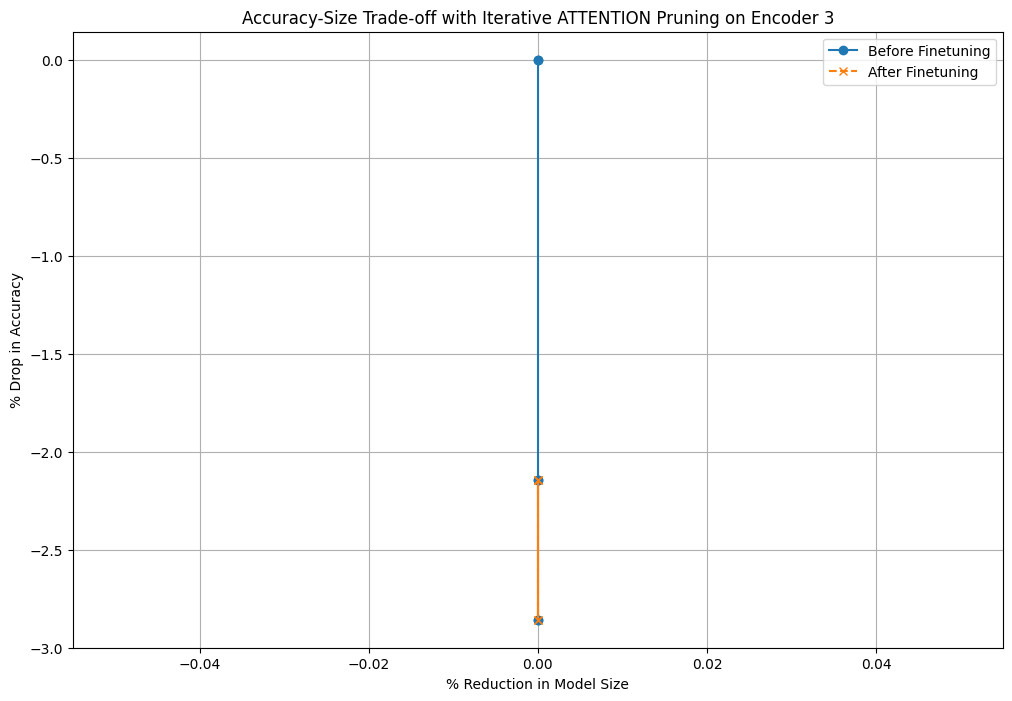

In [65]:
# # Run iterative pruning with fine-tuning
# if args.mode in ['iterative', 'all']:
print("\n=== Running Iterative Pruning with Fine-tuning ===")
all_results = run_iterative_pruning_experiment(
    model_alias=model_alias,
    train_loader=train_loader,
    test_loader=test_loader
)
print("\n=== Pruning Experiments Completed ===")
print(f"Results saved to {model_dir}/pruning/")

In [66]:
def create_combined_sensitivity_plots(model_alias, attention_results, ffn_results):
    """Create combined plots for sensitivity scan results."""
    # Filter out baseline rows
    attention_plot = attention_results[attention_results['encoder_index'] != 'baseline']
    ffn_plot = ffn_results[ffn_results['encoder_index'] != 'baseline']
    
    # Create combined accuracy plot
    plt.figure(figsize=(15, 10))
    
    # Plot attention head pruning
    for encoder_idx in attention_plot['encoder_index'].unique():
        subset = attention_plot[attention_plot['encoder_index'] == encoder_idx]
        plt.plot(subset['prune_percent'], subset['accuracy_drop_percent'], 
                 marker='o', linestyle='-', 
                 label=f'Attention - Encoder {encoder_idx}')
    
    # Plot FFN pruning
    for encoder_idx in ffn_plot['encoder_index'].unique():
        subset = ffn_plot[ffn_plot['encoder_index'] == encoder_idx]
        plt.plot(subset['prune_percent'], subset['accuracy_drop_percent'], 
                 marker='x', linestyle='--', 
                 label=f'FFN - Encoder {encoder_idx}')
    
    plt.title('Sensitivity Scan: Impact of Pruning on Model Accuracy')
    plt.xlabel('% Parameters Pruned')
    plt.ylabel('% Drop in Accuracy')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"model-metric/{model_alias}/pruning/combined_sensitivity_accuracy.png", dpi=300)
    
    # Create combined model size plot
    plt.figure(figsize=(15, 10))
    
    # Plot attention head pruning
    for encoder_idx in attention_plot['encoder_index'].unique():
        subset = attention_plot[attention_plot['encoder_index'] == encoder_idx]
        plt.plot(subset['prune_percent'], subset['size_reduction_percent'], 
                 marker='o', linestyle='-', 
                 label=f'Attention - Encoder {encoder_idx}')
    
    # Plot FFN pruning
    for encoder_idx in ffn_plot['encoder_index'].unique():
        subset = ffn_plot[ffn_plot['encoder_index'] == encoder_idx]
        plt.plot(subset['prune_percent'], subset['size_reduction_percent'], 
                 marker='x', linestyle='--', 
                 label=f'FFN - Encoder {encoder_idx}')
    
    plt.title('Sensitivity Scan: Impact of Pruning on Model Size')
    plt.xlabel('% Parameters Pruned')
    plt.ylabel('% Reduction in Model Size')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"model-metric/{model_alias}/pruning/combined_sensitivity_size.png", dpi=300)
    
    # Create trade-off plot (accuracy drop vs size reduction)
    plt.figure(figsize=(15, 10))
    
    # Plot attention head pruning
    for encoder_idx in attention_plot['encoder_index'].unique():
        subset = attention_plot[attention_plot['encoder_index'] == encoder_idx]
        plt.plot(subset['size_reduction_percent'], subset['accuracy_drop_percent'], 
                 marker='o', linestyle='-', 
                 label=f'Attention - Encoder {encoder_idx}')
    
    # Plot FFN pruning
    for encoder_idx in ffn_plot['encoder_index'].unique():
        subset = ffn_plot[ffn_plot['encoder_index'] == encoder_idx]
        plt.plot(subset['size_reduction_percent'], subset['accuracy_drop_percent'], 
                 marker='x', linestyle='--', 
                 label=f'FFN - Encoder {encoder_idx}')
    
    plt.title('Sensitivity Scan: Accuracy-Size Trade-off')
    plt.xlabel('% Reduction in Model Size')
    plt.ylabel('% Drop in Accuracy')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"model-metric/{model_alias}/pruning/combined_sensitivity_tradeoff.png", dpi=300)


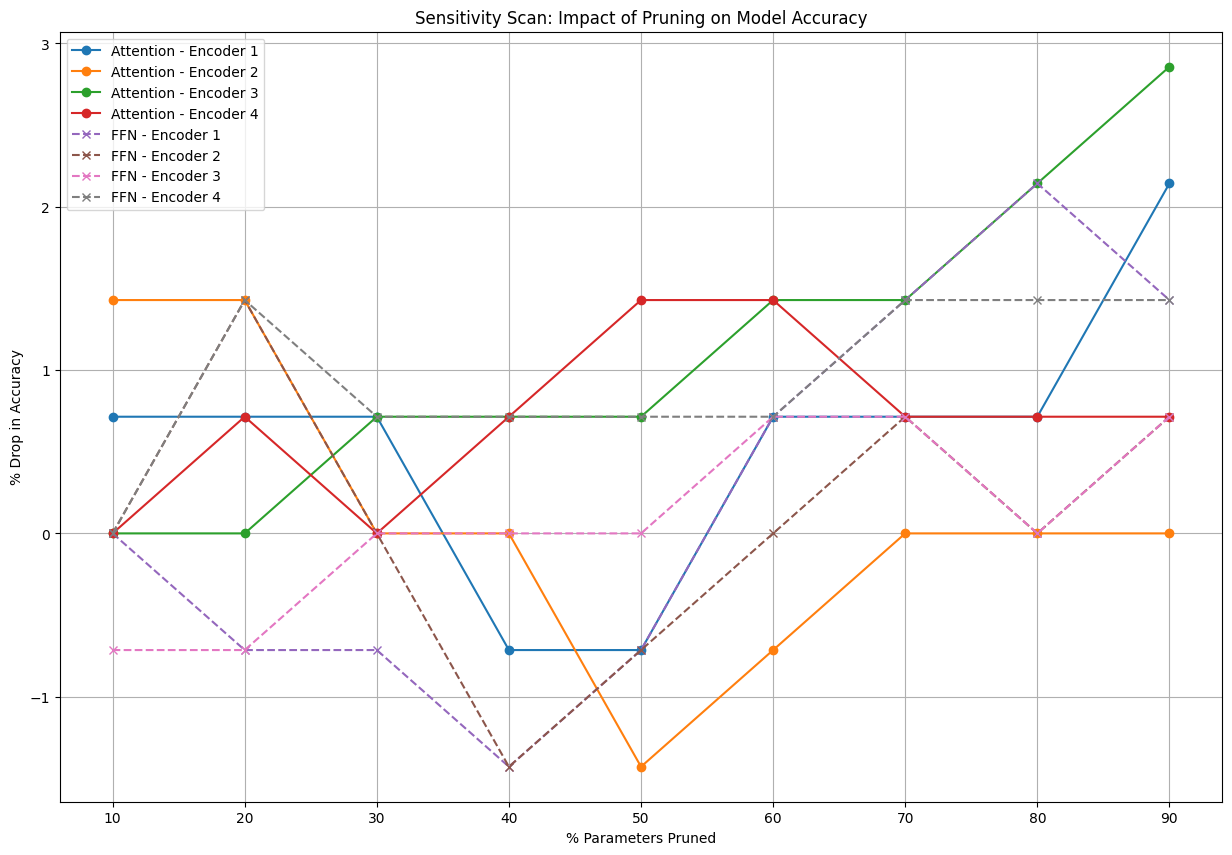

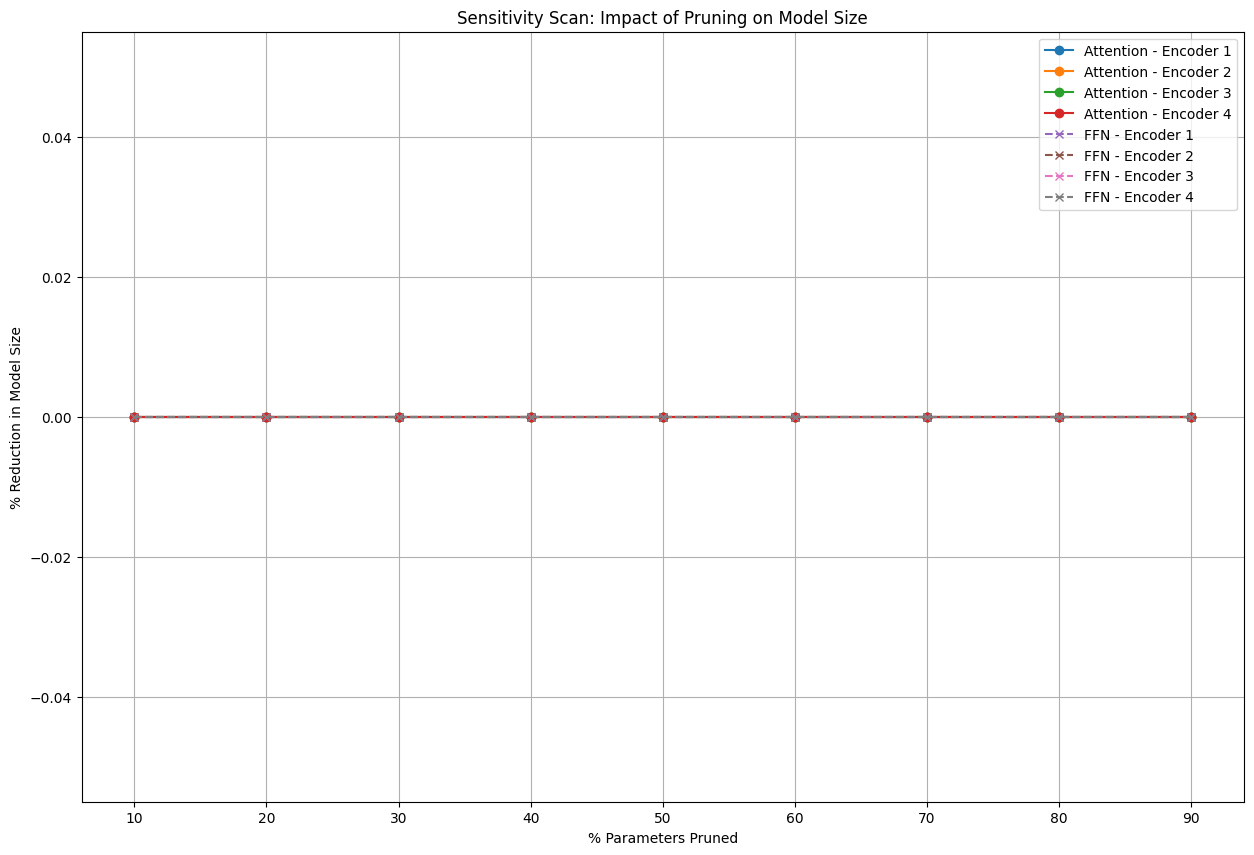

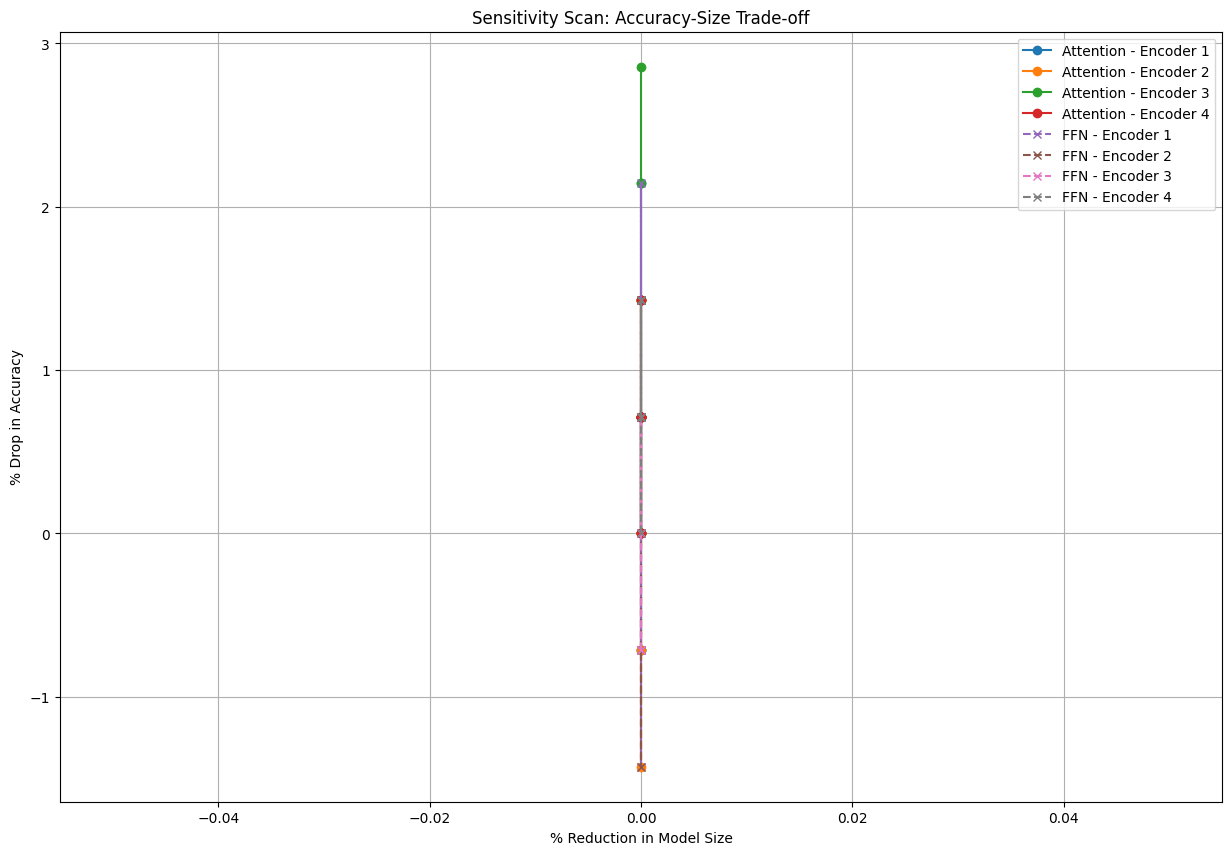

In [67]:
create_combined_sensitivity_plots(model_alias, attention_results, ffn_results)